## Study of the class-variance of features

This notebook is dedicated to studying the class-variance of features of the datasets used to test wether the mean is more robust than robust aggregators.


In [1]:
from torchvision import datasets, transforms
from byzfl import DataDistributor
from torch.utils.data import DataLoader, Subset

In [2]:
#datasets available in byzfl. For now, we do not apply the normalizations because in "mean is more robust", there does not seem to be any.

# transforms_hflip = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
# transforms_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# transforms_cifar_train = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])
# transforms_cifar_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# #Supported datasets
# dict_datasets = {
#     "mnist":        ("MNIST", transforms_mnist, transforms_mnist),
#     "fashionmnist": ("FashionMNIST", transforms_hflip, transforms_hflip),
#     "emnist":       ("EMNIST", transforms_mnist, transforms_mnist),
#     "cifar10":      ("CIFAR10", transforms_cifar_train, transforms_cifar_test),
#     "cifar100":     ("CIFAR100", transforms_cifar_train, transforms_cifar_test),
#     "imagenet":     ("ImageNet", transforms_hflip, transforms_hflip)
# }

dataset_name = "MNIST"

dataset = getattr(datasets, dataset_name)(
            root = "./data", 
            train = True, 
            download = True,
            transform = None
    )

In [21]:


def create_data_splits(data_loader, data_distribution_name, distribution_parameter, nb_honest, batch_size):
    params= {
        "data_loader": data_loader,
        "data_distribution_name": data_distribution_name,
        "nb_honest": nb_honest,
        "batch_size": batch_size,
        "distribution_parameter": distribution_parameter
    }
    distributor = DataDistributor(params)

    ## Ensuite, on reprend la méthode "split data" de DataDistributor, sans crée de dataloader afin de faciliter le plotting:

    targets = data_loader.dataset.targets
    if isinstance(data_loader, DataLoader):
        idx = list(range(len(targets)))
    else:
        idx = data_loader.indices

    if data_distribution_name == "iid":
        split_idx = distributor.iid_idx(idx)
    elif data_distribution_name == "gamma_similarity_niid":
        split_idx = distributor.gamma_niid_idx(targets, idx)
    elif data_distribution_name == "dirichlet_niid":
        split_idx = distributor.dirichlet_niid_idx(targets, idx)
    elif data_distribution_name == "extreme_niid":
        split_idx = distributor.extreme_niid_idx(targets, idx)
    else:
        raise ValueError(f"Invalid value for data_distribution_name: {data_distribution_name}")
        
    ##ENfin, on récupère les données:

    subsets=[]
    for i in range(len(split_idx)):
        subset = Subset(data_loader.dataset, split_idx[i])
        subsets.append(subset)
    return subsets


#Définir les paramètres de la distribution
batch_size = 128

data_distributions=["dirichlet_niid", "iid", "extreme_niid"]

dirichlet_parameter_list=[0.01,0.03,0.05,0.1, 1.0, 10.0]

nb_honest = 10


data_splits = {dist+" α="+str(dirichlet_param) if dirichlet_param else dist: create_data_splits(DataLoader(dataset, batch_size=64, shuffle=True), dist, dirichlet_param, nb_honest, batch_size) for dist in data_distributions for dirichlet_param in (dirichlet_parameter_list if "dirichlet_niid" in dist else [0.0])}


### On peut maintenant plot les distributions par classe par worker:

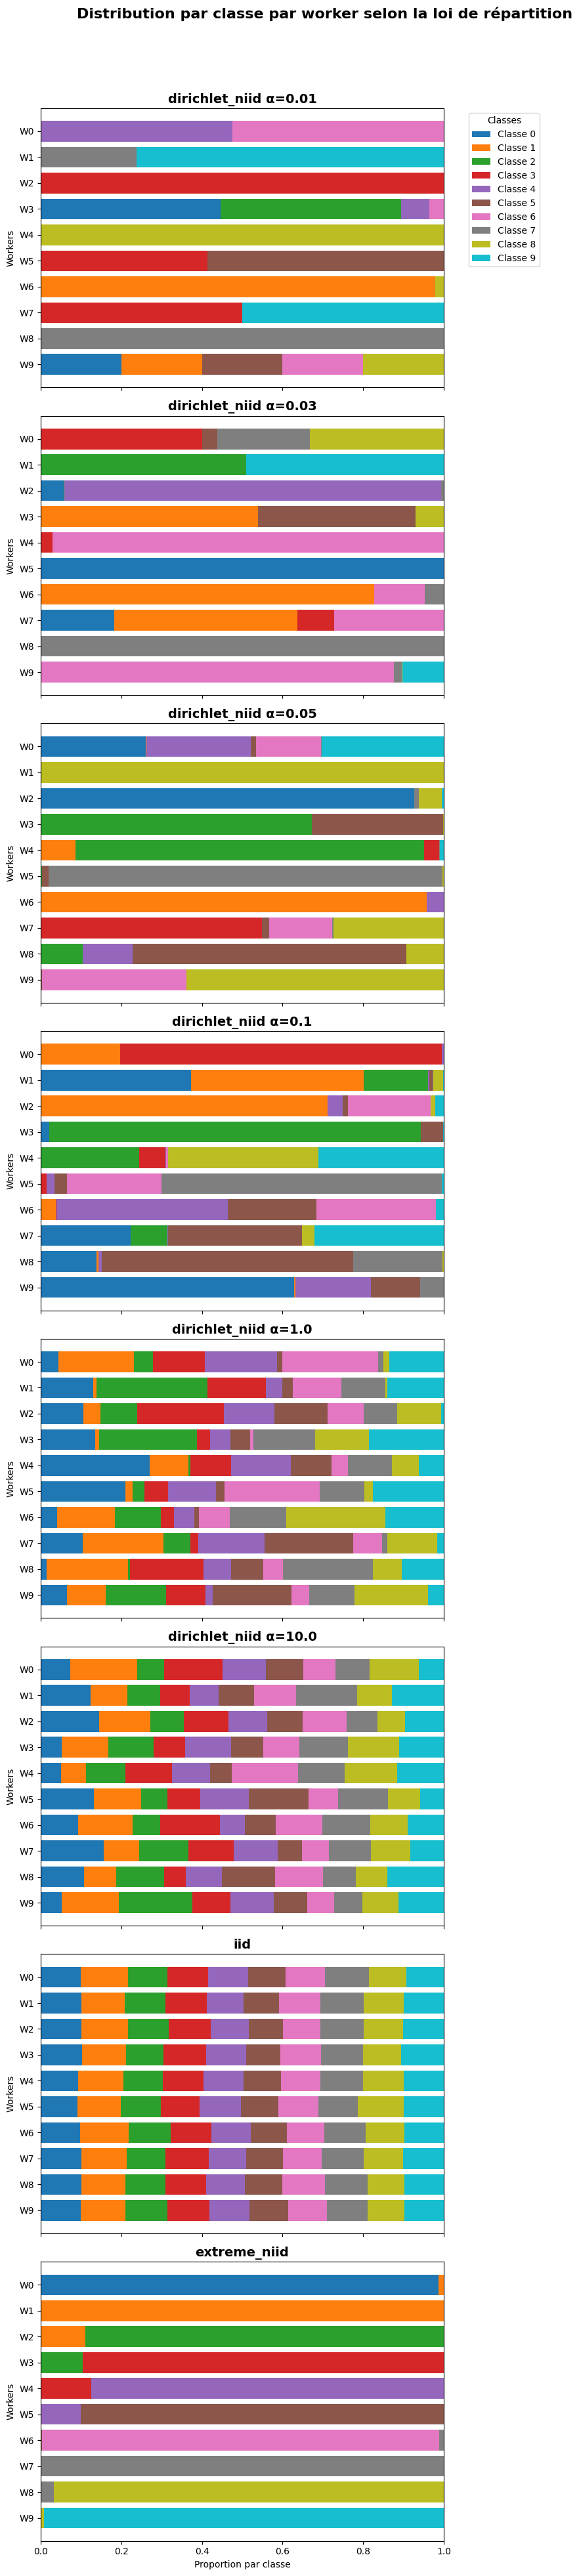

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_worker_distributions_compact(data_splits, num_classes=10):
    """
    data_splits: dict
        Clés = noms des distributions (ex: 'Dirichlet α=0.1')
        Valeurs = liste de Subset (un Subset par worker)
    """
    dist_names = list(data_splits.keys())
    n_dists = len(dist_names)
    colors = plt.cm.tab10.colors  # 10 couleurs pour les classes

    fig, axes = plt.subplots(n_dists, 1, figsize=(10, 5 * n_dists), sharex=True)
    if n_dists == 1:
        axes = [axes]  # pour itérer même s’il y a un seul plot

    for ax, dist_name in zip(axes, dist_names):
        subsets = data_splits[dist_name]
        num_workers = len(subsets)

        # Calcul des proportions par worker
        proportions = []
        for subset in subsets:
            targets = np.array([subset.dataset.targets[idx] for idx in subset.indices])
            counts = Counter(targets)
            total = len(targets)
            prop = [counts.get(c, 0) / total if total > 0 else 0 for c in range(num_classes)]
            proportions.append(prop)
        proportions = np.array(proportions)

        # Plot horizontal empilé
        left = np.zeros(num_workers)
        for c in range(num_classes):
            ax.barh(range(num_workers), proportions[:, c], left=left,
                    color=colors[c], label=f'Classe {c}' if ax == axes[0] else None)
            left += proportions[:, c]

        ax.set_yticks(range(num_workers))
        ax.set_yticklabels([f'W{i}' for i in range(num_workers)])
        ax.set_title(dist_name, fontsize=14, weight='bold')
        ax.set_ylabel('Workers')
        ax.invert_yaxis()  # pour que W0 soit en haut

    axes[-1].set_xlabel('Proportion par classe')
    axes[0].legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle("Distribution par classe par worker selon la loi de répartition", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    plt.show()
    
plot_worker_distributions_compact(data_splits)



### Enfin, on calcule la variance des features par worker

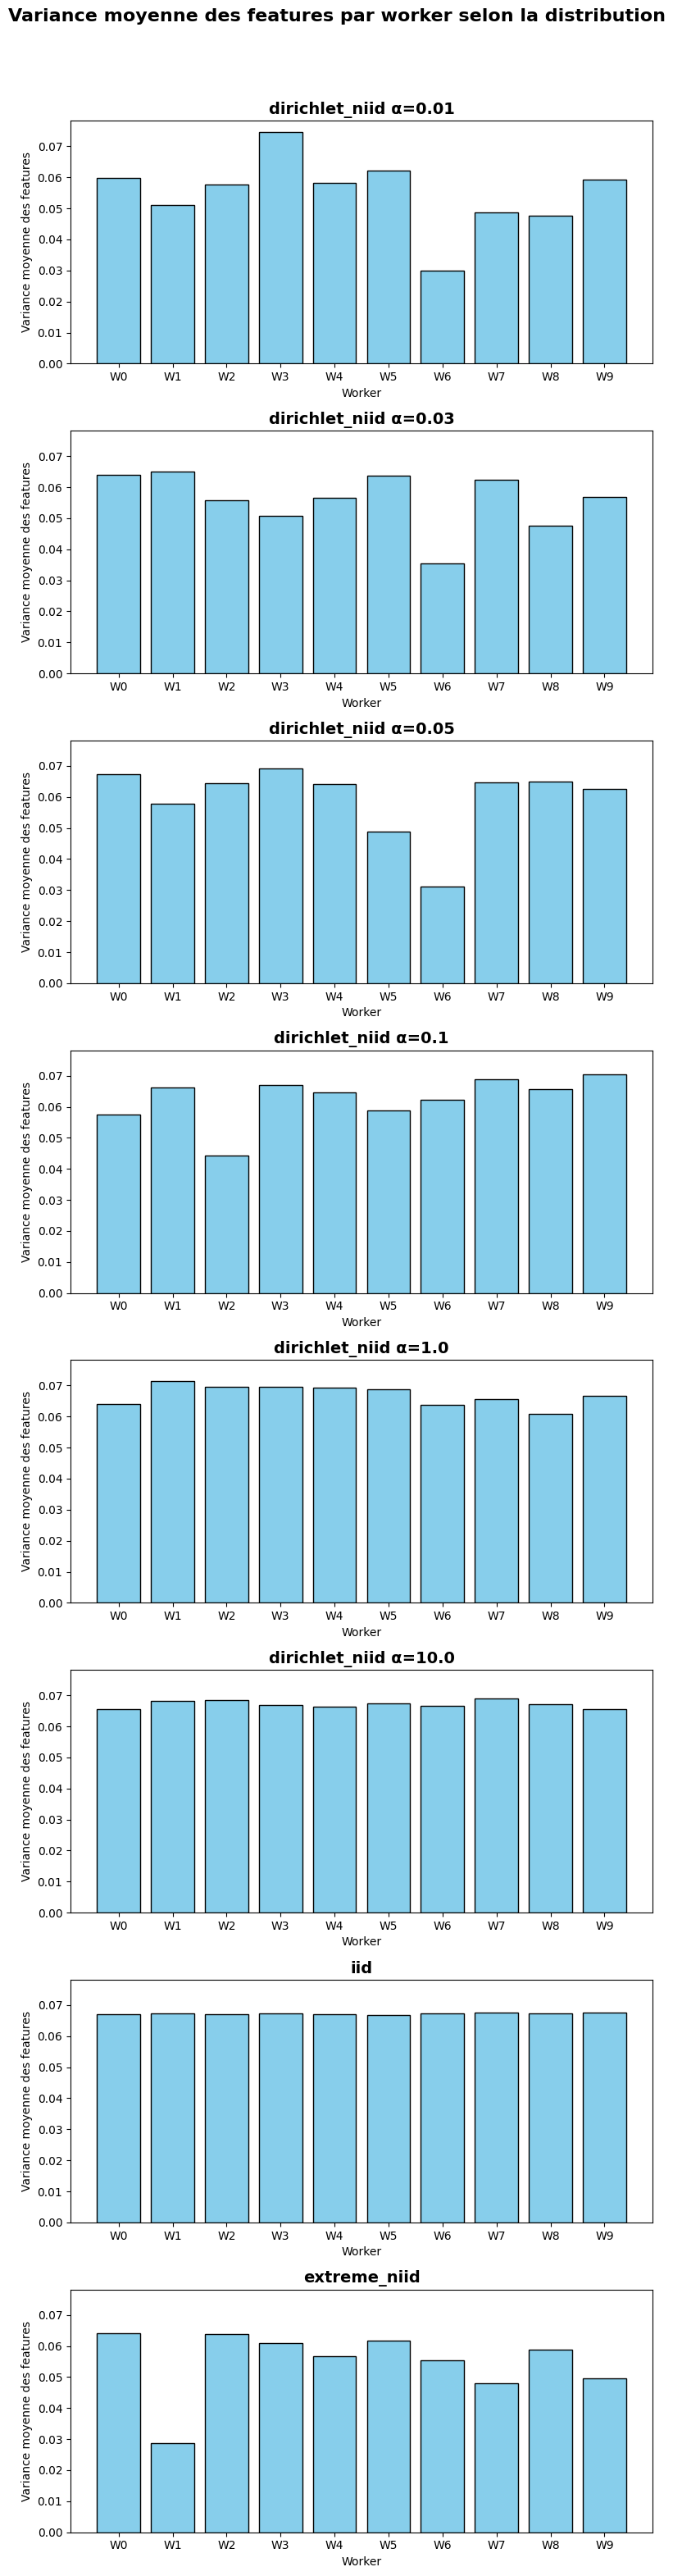

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from torchvision import transforms

from torchvision import transforms
import torch

to_tensor = transforms.ToTensor()

def compute_feature_variances_flatten(subsets):
    """
    Pour chaque worker, flatten toutes les images en vecteur et calculer
    la variance globale sur tous les pixels.
    """
    variances = []
    for subset in subsets:
        # flatten toutes les images et convertir en Tensor si nécessaire
        all_pixels = torch.cat([
            to_tensor(subset.dataset[i][0]).view(-1).float()
            if not isinstance(subset.dataset[i][0], torch.Tensor)
            else subset.dataset[i][0].view(-1).float()
            for i in subset.indices
        ])
        # variance globale sur tous les pixels
        variances.append(torch.var(all_pixels).item())
    return np.array(variances)



def plot_feature_variances_compact(data_splits):
    """
    data_splits: dict
        Clés = noms des distributions
        Valeurs = liste de Subset (un par worker)
    """
    dist_names = list(data_splits.keys())
    n_dists = len(dist_names)

    fig, axes = plt.subplots(n_dists, 1, figsize=(8, 4 * n_dists), sharey=True)
    if n_dists == 1:
        axes = [axes]

    for ax, dist_name in zip(axes, dist_names):
        subsets = data_splits[dist_name]
        variances = compute_feature_variances(subsets)
        num_workers = len(variances)

        ax.bar(range(num_workers), variances, color="skyblue", edgecolor="black")
        ax.set_title(dist_name, fontsize=14, weight='bold')
        ax.set_xlabel("Worker")
        ax.set_ylabel("Variance moyenne des features")

        ax.set_xticks(range(num_workers))
        ax.set_xticklabels([f"W{i}" for i in range(num_workers)])

    plt.suptitle("Variance moyenne des features par worker selon la distribution", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
plot_feature_variances_compact(data_splits)
